In [1]:
!pip install catalyst==20.12
!pip install pretrainedmodels
!pip install https://www.piwheels.org/simple/segmentation-models-pytorch/segmentation_models_pytorch-0.3.0-py3-none-any.whl
!pip install pytorch_toolbelt
!pip install torchvision

  Using cached https://www.piwheels.org/simple/segmentation-models-pytorch/segmentation_models_pytorch-0.3.0-py3-none-any.whl (97 kB)


In [2]:
import torch
print(torch.__version__)

2.4.0


## Importing libraries

In [3]:
import sys

if sys.version_info.major == 3 and sys.version_info.minor >= 10:
    import collections
    setattr(collections, "MutableMapping", collections.abc.MutableMapping)

import os
import cv2
import collections
import time 
import tqdm
from PIL import Image
from functools import partial
train_on_gpu = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Helper functions and classes

In [4]:
def get_img(x, folder: str='train_images'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{path}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')


def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)
        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)


    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)


    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)
    
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Resize(320, 640)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640)
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

## Data overview

Давайте сначала посмотрим на данные

In [5]:
path = '../input/understanding_cloud_organization'
os.listdir(path)

['sample_submission.csv', 'train_images', 'train.csv', 'test_images']

У нас есть папки с учебными и тестовыми изображениями, файл с идентификаторами учебных изображений и масками, а также образцы

In [6]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [7]:
train.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

In [8]:
n_train = len(os.listdir(f'{path}/train_images'))
n_test = len(os.listdir(f'{path}/test_images'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


In [9]:
train['Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Image_Label
Fish      5546
Flower    5546
Gravel    5546
Sugar     5546
Name: count, dtype: int64

Итак, в наборе данных для обучения имеется около 5,5 тыс. изображений, и они могут иметь до 4 масок: «Рыба», «Цветок», «Гравий» и «Сахар»

In [10]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Image_Label
Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: count, dtype: int64

In [11]:
train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

count
2    2372
3    1560
1    1348
4     266
Name: count, dtype: int64

Но есть много пустых масок. Фактически только 266 изображений имеют все четыре маски. Важно помнить об этом

In [12]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])


sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

Давайте посмотрим на изображения и маски.

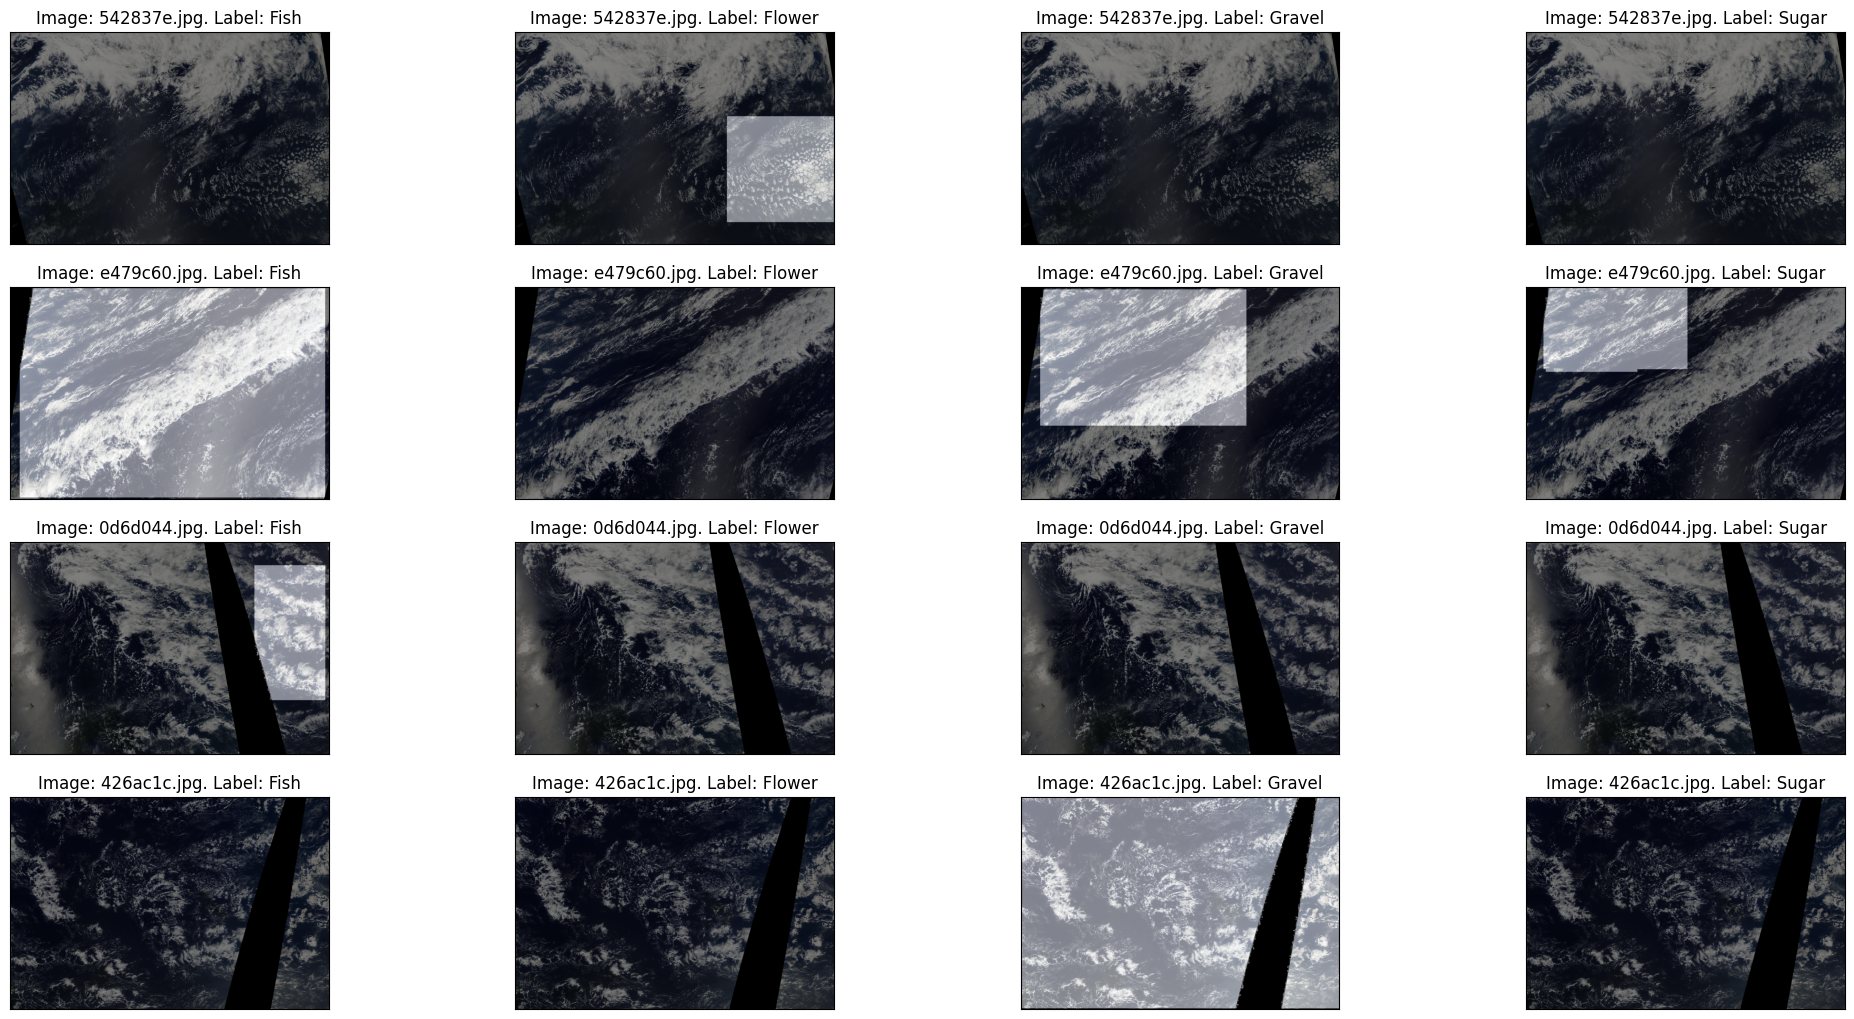

In [13]:
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train['im_id'].unique(), 4)):
    for i, (idx, row) in enumerate(train.loc[train['im_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{path}/train_images/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        try: # label might not be there!
            mask = rle_decode(mask_rle)
        except:
            mask = np.zeros((1400, 2100))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

Мы видим, что маски могут перекрываться. Также мы видим, что облака действительно похожи на рыбу, цветок и т. д. Еще один важный момент: маски часто довольно большие и могут иметь кажущиеся пустыми области

## Подготовка данных для моделирования

Сначала создадим список уникальных идентификаторов изображений и количество масок для изображений. Это позволит нам сделать стратифицированное разделение на основе этого количества

In [14]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'Image_Label': 'img_id'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

## Исследование аугументаций с albumentations

Одной из важных вещей при работе с изображениями является выбор хороших аугментаций. Их много, давайте рассмотрим аугментации с альбументациями

In [15]:
image_name = '8242ba0.jpg'
image = get_img(image_name)
mask = make_mask(train, image_name)

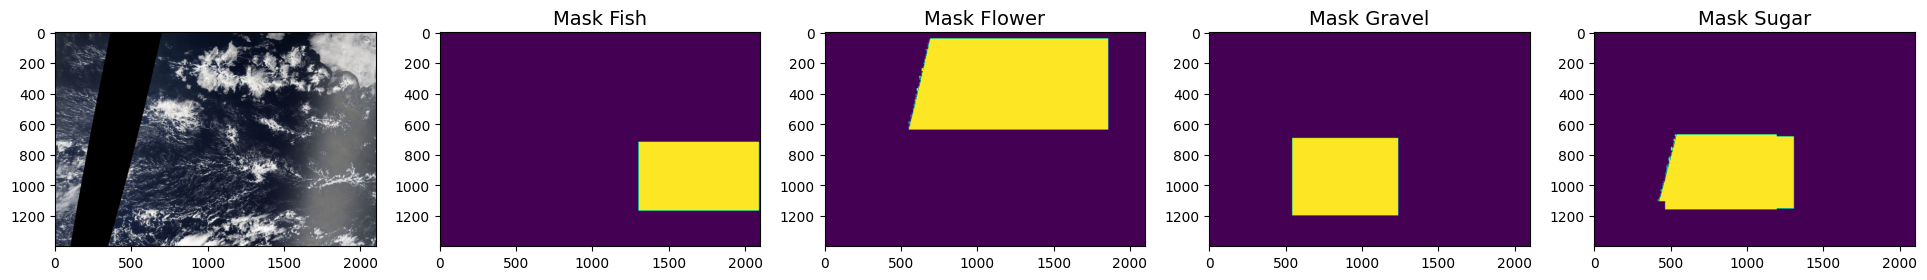

In [16]:
visualize(image, mask)

This is how original image and its masks look like. Let's try adding some augmentations

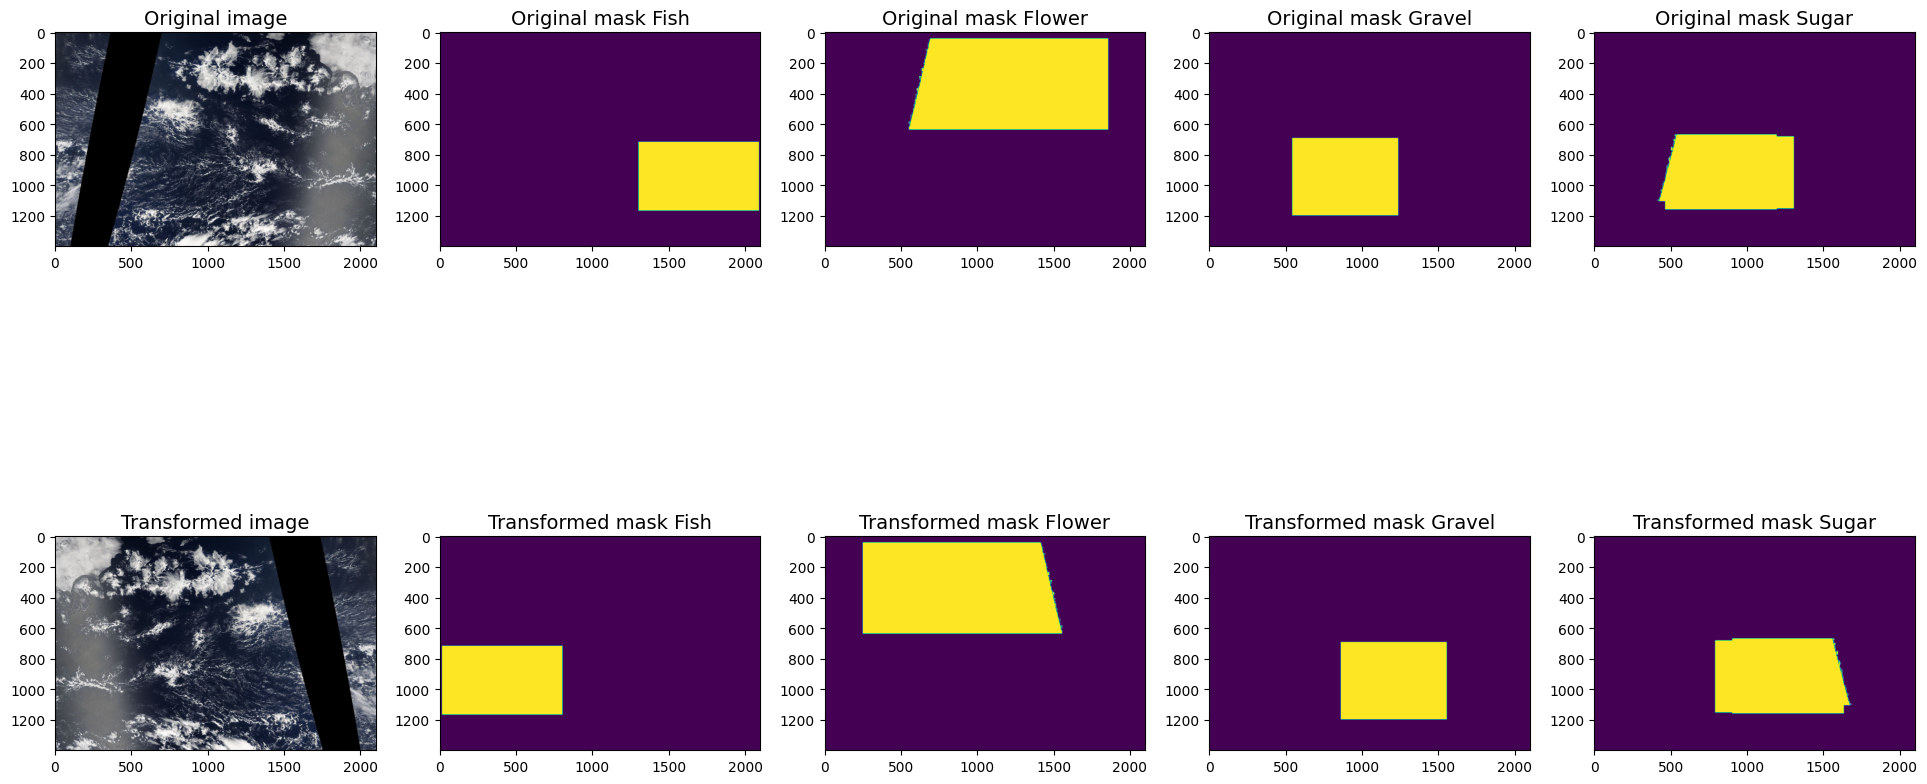

In [17]:
plot_with_augmentation(image, mask, albu.HorizontalFlip(p=1))

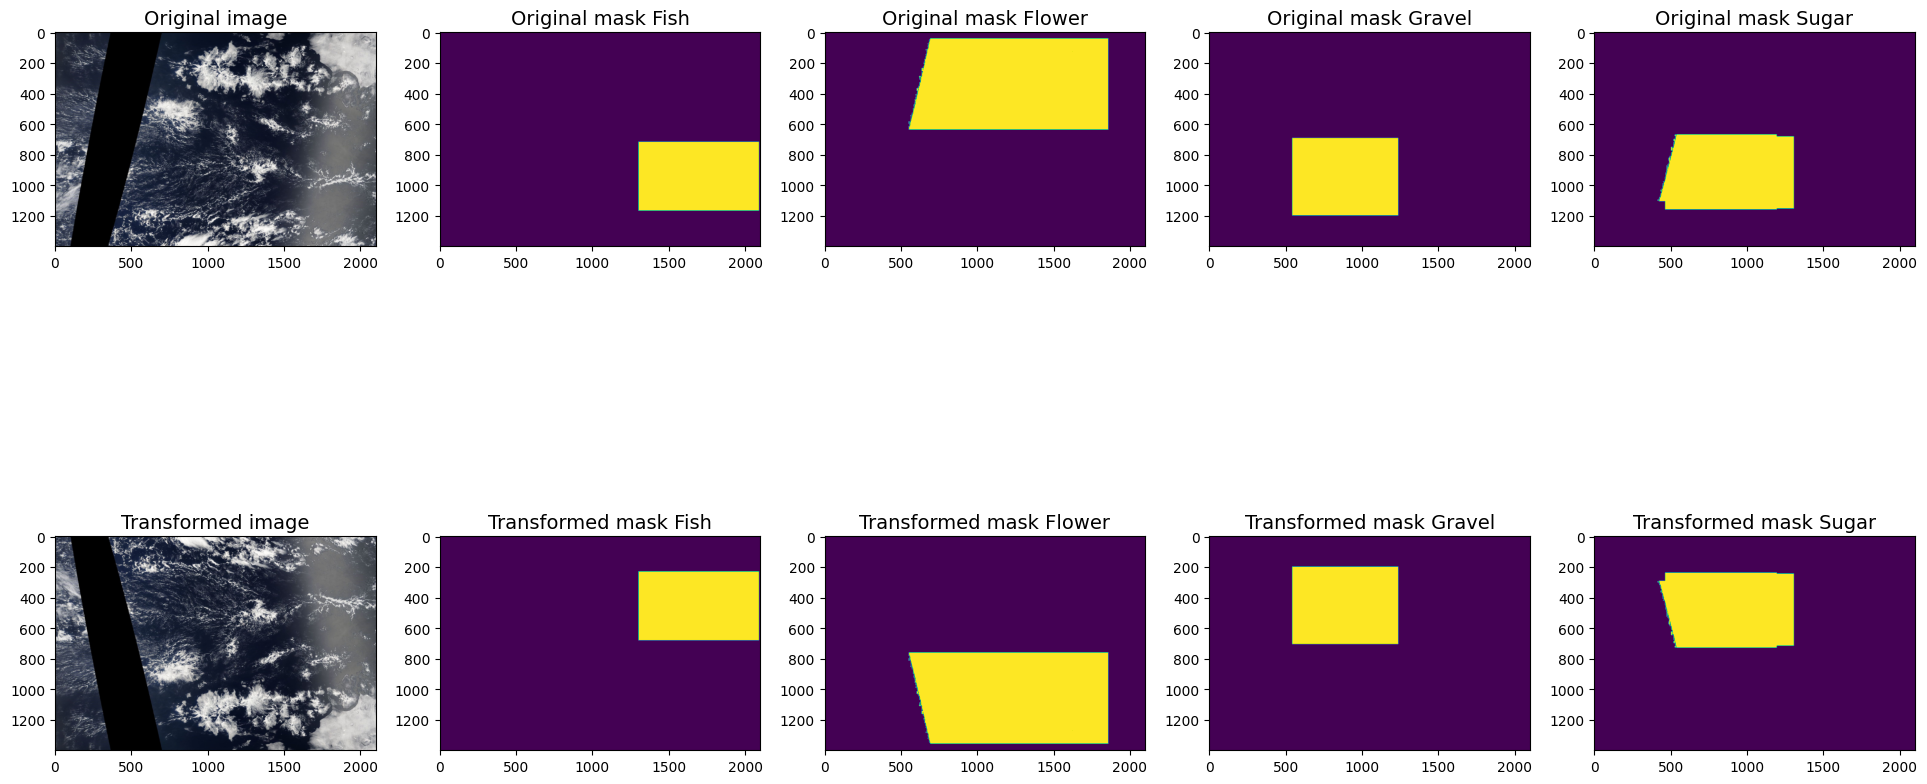

In [18]:
plot_with_augmentation(image, mask, albu.VerticalFlip(p=1))

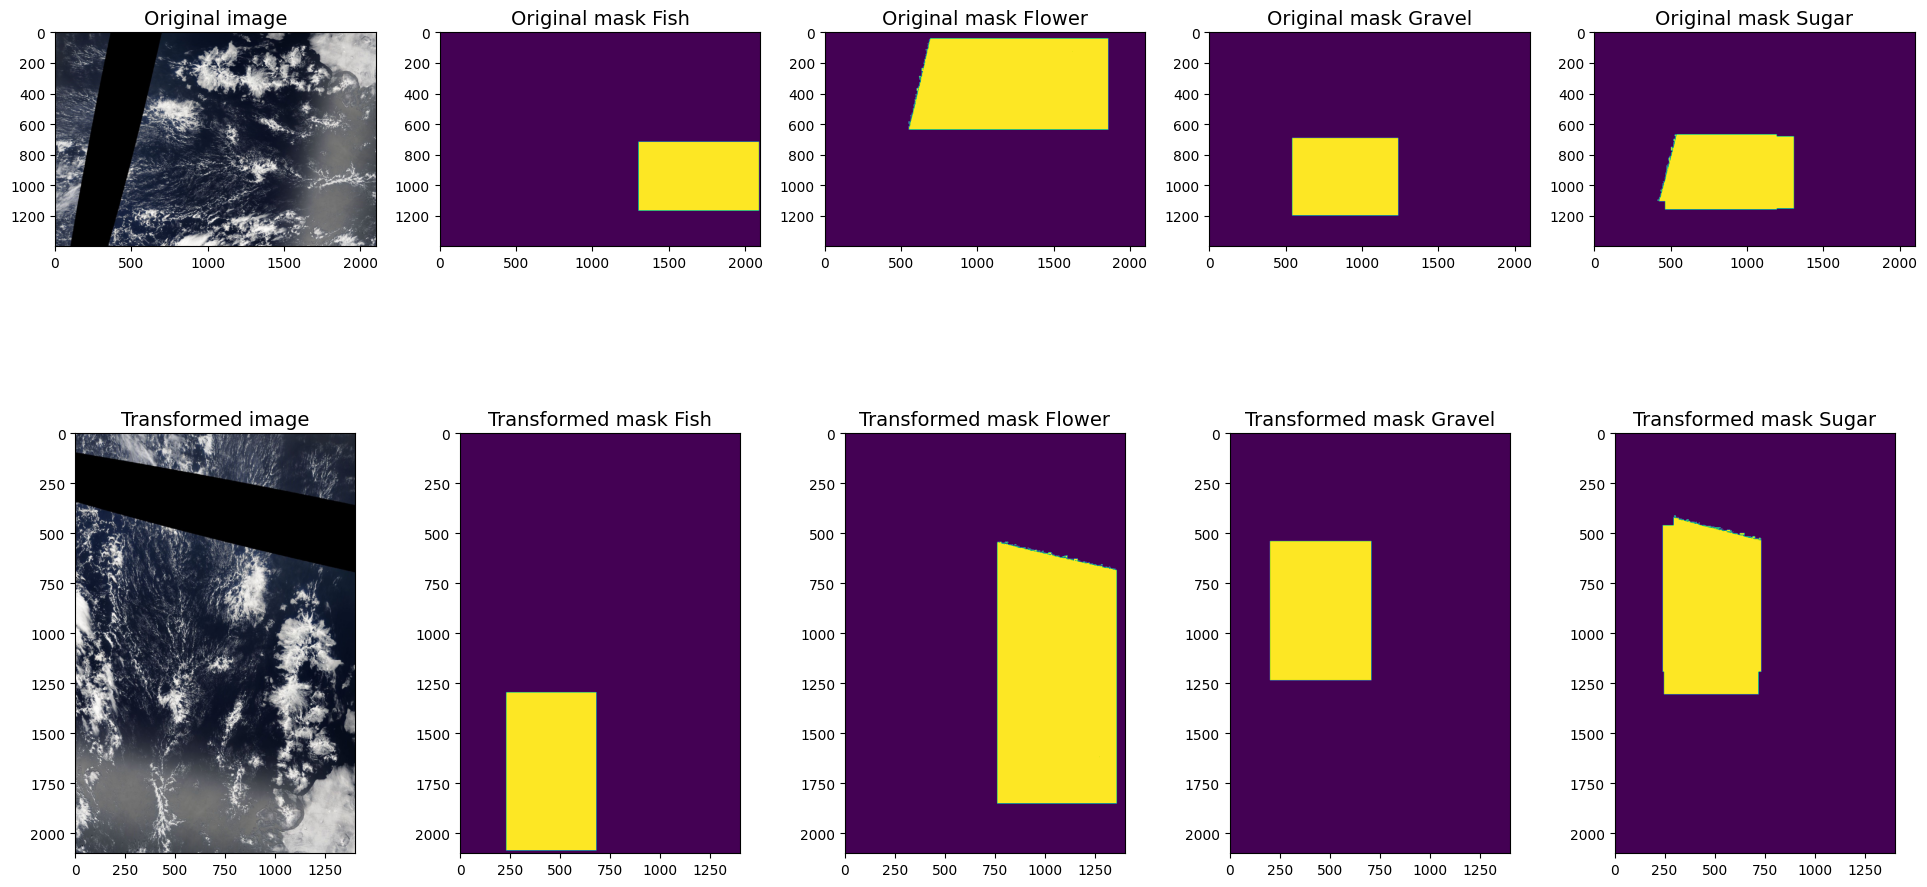

In [19]:
plot_with_augmentation(image, mask, albu.RandomRotate90(p=1))

In [20]:
#plot_with_augmentation(image, mask, albu.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03))

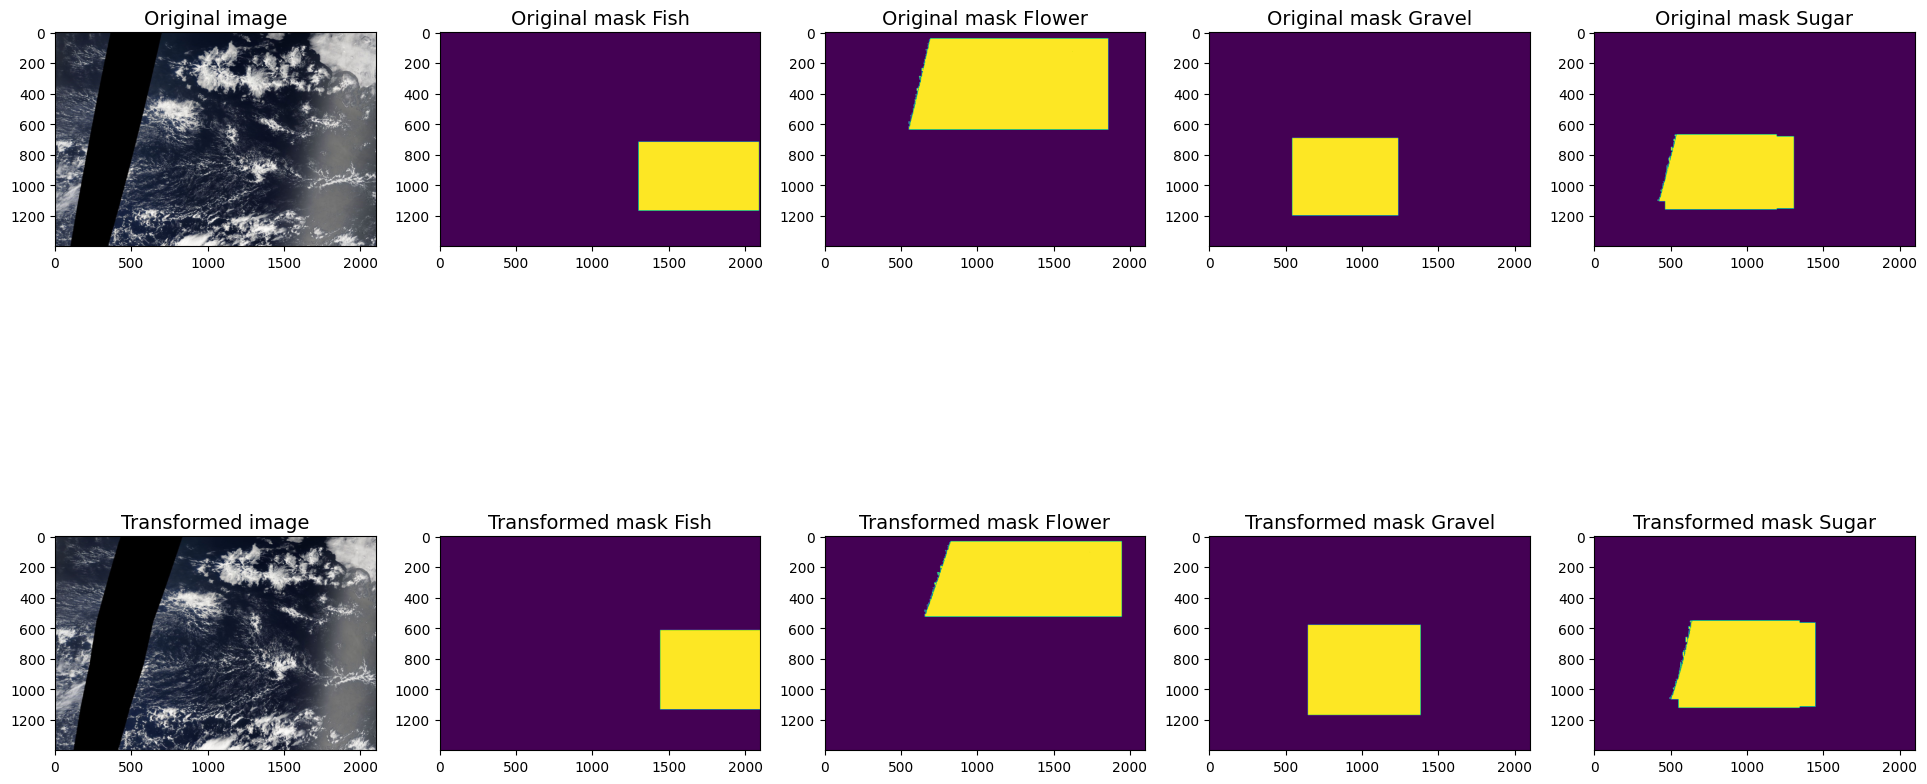

In [21]:
plot_with_augmentation(image, mask, albu.GridDistortion(p=1))

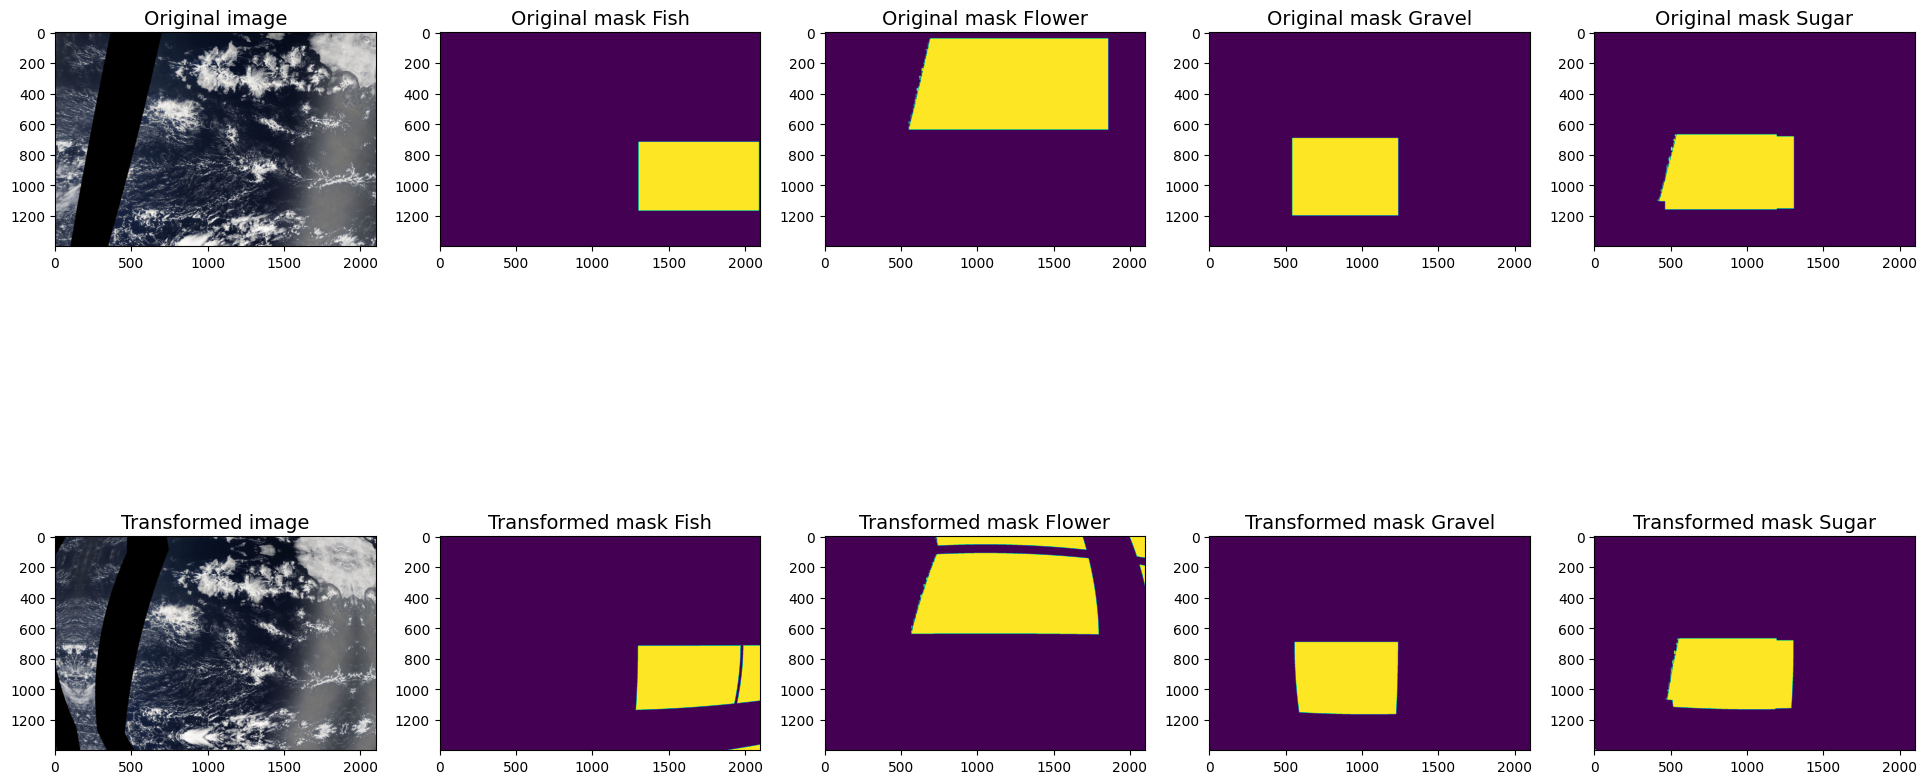

In [22]:
plot_with_augmentation(image, mask, albu.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5))

## Setting up data for training in Catalyst

In [23]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = albu.Compose([albu.HorizontalFlip(),ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{path}/train_images"
        else:
            self.data_folder = f"{path}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

Теперь определим параметры модели и обучения

In [24]:
import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [25]:
num_workers = 0
bs = 16
train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [26]:
!rm -rf ./logs/segmentation
!rm -rf ./csv

In [27]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

In [28]:
from catalyst.dl.runner import SupervisedRunner

num_epochs = 16
logdir = "./logs/segmentation"

# model, criterion, optimizer
optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-2}, 
    {'params': model.encoder.parameters(), 'lr': 1e-3},  
])
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
criterion = BCEDiceLoss(eps=1.)
runner = SupervisedRunner()

/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning:

`torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.



## Model training

In [29]:
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback, CSVLogger

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=[
        DiceCallback(),
        EarlyStoppingCallback(patience=5, min_delta=0.001),
        CSVLogger()
    ],
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

1/16 * Epoch (train):   0% 0/312 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



1/16 * Epoch (train): 100% 312/312 [19:26<00:00,  3.74s/it, dice=0.359, loss=0.952]
1/16 * Epoch (valid): 100% 35/35 [01:00<00:00,  1.73s/it, dice=0.381, loss=1.186]
[2024-09-23 18:44:14,261] 
1/16 * Epoch 1 (_base): lr=0.0100 | momentum=0.9000
1/16 * Epoch 1 (train): dice=0.3363 | loss=1.0432
1/16 * Epoch 1 (valid): dice=0.4025 | loss=1.1239
2/16 * Epoch (train): 100% 312/312 [17:51<00:00,  3.43s/it, dice=0.426, loss=0.866]
2/16 * Epoch (valid): 100% 35/35 [00:59<00:00,  1.71s/it, dice=0.432, loss=0.871]
[2024-09-23 19:03:07,563] 
2/16 * Epoch 2 (_base): lr=0.0100 | momentum=0.9000
2/16 * Epoch 2 (train): dice=0.3899 | loss=0.9465
2/16 * Epoch 2 (valid): dice=0.4280 | loss=0.9062
3/16 * Epoch (train): 100% 312/312 [18:00<00:00,  3.46s/it, dice=0.467, loss=0.854]
3/16 * Epoch (valid): 100% 35/35 [01:01<00:00,  1.77s/it, dice=0.479, loss=0.828]
[2024-09-23 19:22:12,880] 
3/16 * Epoch 3 (_base): lr=0.0100 | momentum=0.9000
3/16 * Epoch 3 (train): dice=0.4091 | loss=0.9221
3/16 * Epoch 3 

In [30]:
!mkdir ./csv -p
!mv ./logs/segmentation/train_log/logs.csv ./csv/train.csv
!mv ./logs/segmentation/valid_log/logs.csv ./csv/valid.csv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [31]:
train_results = pd.read_csv('./csv/train.csv')
valid_results = pd.read_csv('./csv/valid.csv')
display(train_results, valid_results)

step      dice      loss
0      1  0.336291  1.043163
1      2  0.389876  0.946479
2      3  0.409073  0.922056
3      4  0.422284  0.907388
4      5  0.430598  0.893926
5      6  0.451732  0.861625
6      7  0.452992  0.855580
7      8  0.462937  0.846777
8      9  0.461377  0.846897
9     10  0.466933  0.835654
10    11  0.469314  0.835105
11    12  0.470549  0.829805
12    13  0.469469  0.830584
13    14  0.475836  0.823209
14    15  0.480544  0.811347
15    16  0.480654  0.816000

step      dice      loss
0      1  0.402524  1.123913
1      2  0.427959  0.906205
2      3  0.465541  0.915451
3      4  0.441242  0.933258
4      5  0.450614  0.907008
5      6  0.491300  0.810079
6      7  0.501190  0.790939
7      8  0.491999  0.796823
8      9  0.505783  0.797806
9     10  0.502416  0.789140
10    11  0.505053  0.795523
11    12  0.501306  0.794922
12    13  0.498142  0.798045
13    14  0.512943  0.777007
14    15  0.512851  0.779783
15    16  0.512849  0.773139

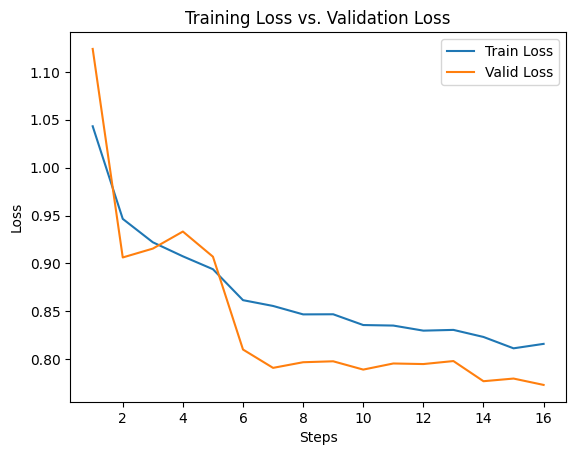

In [32]:
import matplotlib.pyplot as plt

train_loss = train_results['loss']
valid_loss = valid_results['loss']
steps = train_results['step']

plt.plot(steps, train_loss, label='Train Loss')
plt.plot(steps, valid_loss, label='Valid Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss vs. Validation Loss')
plt.legend()
plt.show()


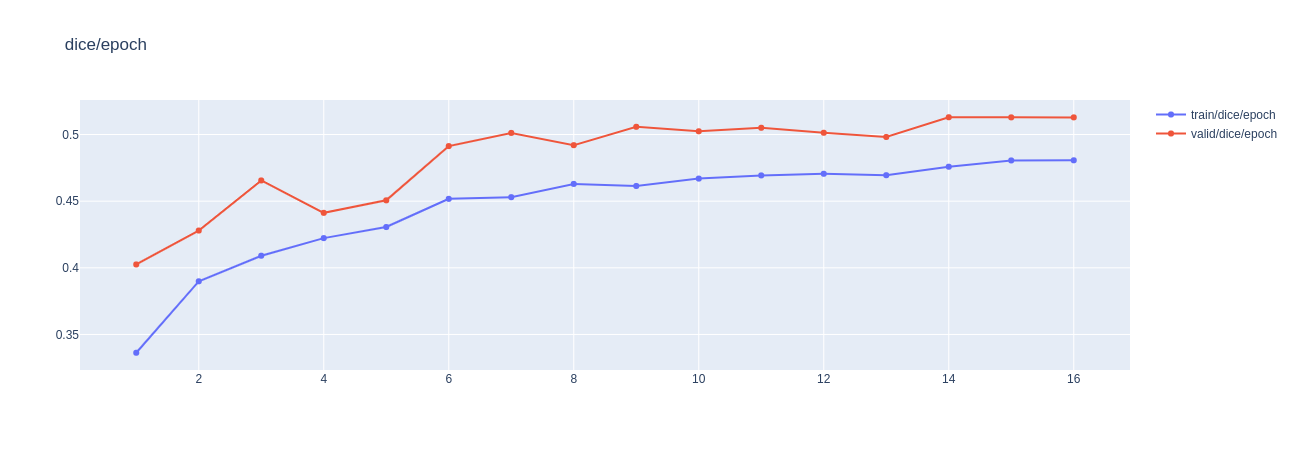

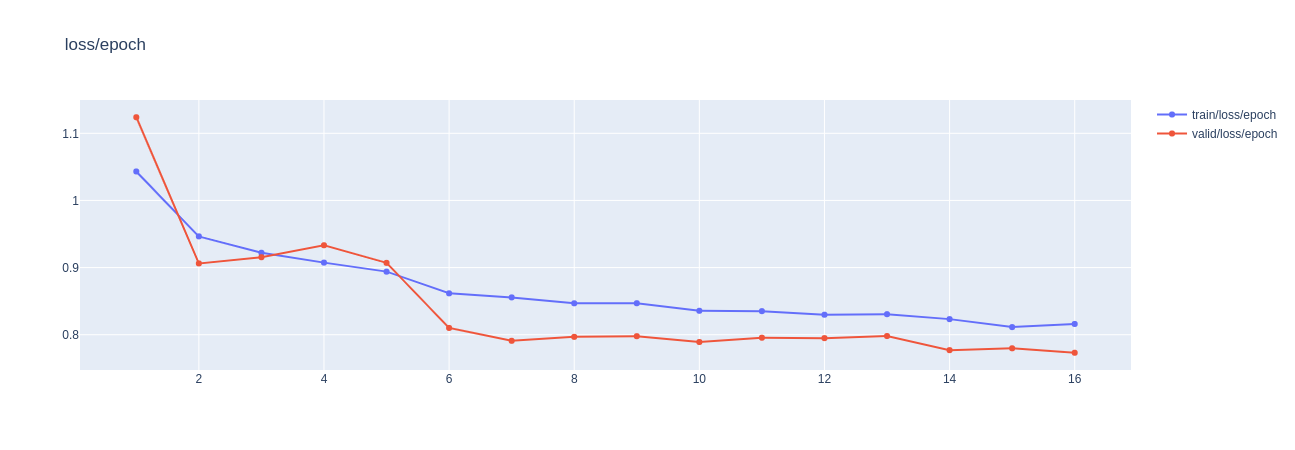

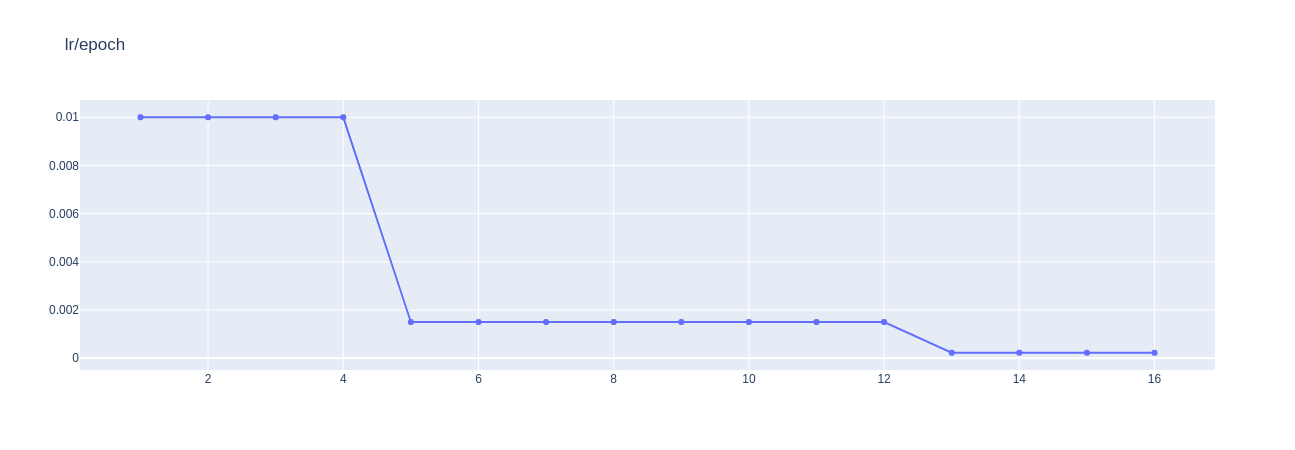

In [33]:
from catalyst.contrib import utils
utils.plot_metrics(
    logdir=logdir, 
    # specify which metrics we want to plot
    metrics=["loss", "dice", 'lr', '_base/lr']
)

# Выводы

* BCEDiceLoss последовательно растет и стабилизируется после 12 эпохи обучения, что говорит о достижении баланса пиксельной точности и локализации границ между предсказанными и целевыми значениями масок
* Функция потерь (loss) снижается и к концу обучения значения для train/val выборки практически совпадают

Это означает, что в целом наша модель обучилась и может быть использована для задачи сегментации типов облаков.